In [9]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .config("spark.driver.memory", "16g")\
    .getOrCreate()

spark

In [88]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.sql.window import Window
from pyspark.sql.functions import col, lit

from common import *

pd.set_option('display.max_rows', 300)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
def event_diff(spark, prefix, from_event, to_event, groupby_home=False, groupby_machine=True, **kwargs):
    txn_info = transactions_csv(spark, prefix, **kwargs)\
        .withColumn("num_replicas", F.size(col("replicas")))\
        .withColumn("num_partitions", F.size(col("partitions")))\
        .withColumn("coordinator_region", col("machine").cast(T.IntegerType()))\
        .drop("min_received_at", "max_received_at", "sent_at", "received_at", "machine")

    groupby = ["txn_id"]
    if groupby_home:
        groupby.append("home")
    if groupby_machine:
        groupby.append("machine")
    txn_events = txn_events_csv(spark, prefix)\
        .where(col("event").isin([from_event, to_event]))\
        .groupBy(*groupby).pivot("event").max("time")\
        .select(
            *groupby,
            col(from_event).alias("from"),
            col(to_event).alias("to"),
            ((col(to_event) - col(from_event)) / 1000000).alias(f"diff")
        )\
        .dropna()
    return txn_events.join(txn_info, on="txn_id")


def plot_cdf_per_region(axes, df, col, **kwargs):
    cols = axes.shape[1]
    for i in range(axes.size):
        r, c = i // cols, i % cols
        arr = df.loc[df.coordinator_region == i, col]
        plot_cdf(ax[r, c], arr, linewidth=0, marker='o', **kwargs)
        ax[r, c].set_title(f"region = {i}")
        ax[r, c].set_xlabel("latency (ms)")


# Lock-hold time

In [143]:
 'ENTER_SERVER',
'EXIT_SERVER_TO_FORWARDER',
'',
'ENTER_FORWARDER',
'EXIT_FORWARDER_TO_SEQUENCER',
'EXIT_FORWARDER_TO_MULTI_HOME_ORDERER',
'ENTER_MULTI_HOME_ORDERER',
'ENTER_MULTI_HOME_ORDERER_IN_BATCH',
'EXIT_MULTI_HOME_ORDERER',
'ENTER_SEQUENCER',
'EXIT_SEQUENCER_IN_BATCH',
'',
'ENTER_LOG_MANAGER_IN_BATCH',
'EXIT_LOG_MANAGER',
'',
'ENTER_SCHEDULER',
'ENTER_SCHEDULER_LO',
'ENTER_LOCK_MANAGER',
'DISPATCHED_FAST',
'DISPATCHED_SLOW',
'DISPATCHED_SLOW_DEADLOCKED',
'ENTER_WORKER',
'EXIT_WORKER',
'',
'RETURN_TO_SERVER',
'EXIT_SERVER_TO_CLIENT'
'',

('',)

In [98]:
PREFIX = "main/ycsb"
SAMPLE = 1.0

# from_event = "ENTER_WORKER"
# to_event = "EXIT_WORKER"

from_event = "ENTER_LOG_MANAGER_IN_BATCH"
to_event = "EXIT_LOG_MANAGER"

# from_event = "EXIT_LOG_MANAGER"
# to_event = "ENTER_WORKER"

df1 = event_diff(spark, f"file:/home/ctring/data/detock/test/backup/ddr_ts-hot10000mp0mh15", from_event, to_event, groupby_home=True, groupby_machine=True)\
    .sample(fraction=SAMPLE)\
    .toPandas()
# df2 = event_diff(spark, f"file:/home/ctring/data/detock/test/ycsb/baseline-hot10000mp0mh15", from_event, to_event, groupby_home=True, groupby_machine=True)\
#     .sample(fraction=SAMPLE)\
#     .toPandas()


In [99]:
PREFIX = "main/ycsb"
SAMPLE = 1.0

# from_event = "ENTER_WORKER"
# to_event = "EXIT_WORKER"

from_event = "ENTER_LOG_MANAGER_ORDER"
to_event = "EXIT_LOG_MANAGER"

# from_event = "EXIT_LOG_MANAGER"
# to_event = "ENTER_WORKER"

df2 = event_diff(spark, f"file:/home/ctring/data/detock/test2/ycsb-4/ddr_ts-hot10000", from_event, to_event, groupby_home=True, groupby_machine=True)\
    .sample(fraction=SAMPLE)\
    .toPandas()


In [100]:
df1.coordinator_region = df1.machine.values >> 24
df2.coordinator_region = df2.machine.values >> 24


In [ ]:
dfx = df1[df1.num_replicas > 1]
dfx["region2"] = dfx.apply(lambda r: [x for x in r.replicas if x != r.coordinator_region][0], axis=1)
dfx

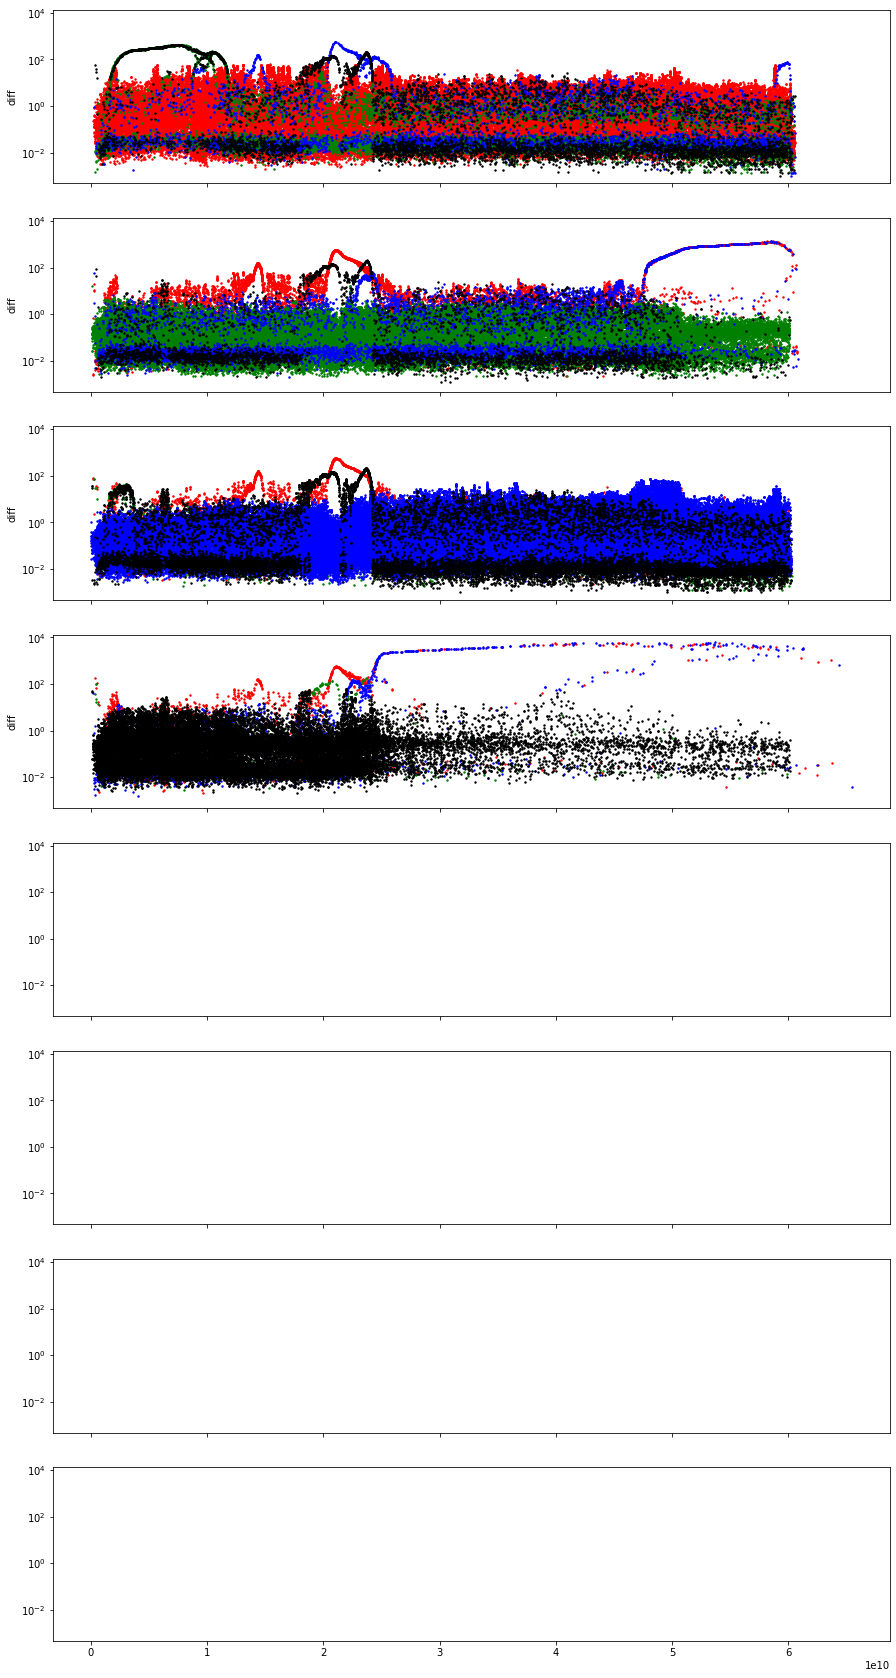

In [102]:
_, ax = plt.subplots(8, 1, figsize=(15, 30), sharey=True, sharex=True)
df1.loc[:, "from"] = normalize(df1.loc[:, "from"])
df1.loc[:, "to"] = normalize(df1.loc[:, "to"])

# df2.loc[:, "from"] = normalize(df2.loc[:, "from"])


for i in range(4):
    df1[(df1.coordinator_region == i) & (df1.home == 0)].sample(frac=1).sort_values("from").plot(x="from", y="diff", logy=True, kind='scatter', s=2, ax=ax[i], color='r')
    df1[(df1.coordinator_region == i) & (df1.home == 1)].sample(frac=1).sort_values("from").plot(x="from", y="diff", logy=True, kind='scatter', s=2, ax=ax[i], color='g')  
    df1[(df1.coordinator_region == i) & (df1.home == 2)].sample(frac=1).sort_values("from").plot(x="from", y="diff", logy=True, kind='scatter', s=2, ax=ax[i], color='b')
    df1[(df1.coordinator_region == i) & (df1.home == 3)].sample(frac=1).sort_values("from").plot(x="from", y="diff", logy=True, kind='scatter', s=2, ax=ax[i], color='k')

    # df2[(df2.coordinator_region == i) & (df2.home == 0)].sample(frac=1).sort_values("from").plot(x="from", y="diff", logy=True, kind='scatter', s=2, ax=ax[i], color='r')
    # df2[(df2.coordinator_region == i) & (df2.home == 1)].sample(frac=1).sort_values("from").plot(x="from", y="diff", logy=True, kind='scatter', s=2, ax=ax[i], color='g')  
    # df2[(df2.coordinator_region == i) & (df2.home == 2)].sample(frac=1).sort_values("from").plot(x="from", y="diff", logy=True, kind='scatter', s=2, ax=ax[i], color='b')
    # df2[(df2.coordinator_region == i) & (df2.home == 3)].sample(frac=1).sort_values("from").plot(x="from", y="diff", logy=True, kind='scatter', s=2, ax=ax[i], color='k')

    # df1[(df1.coordinator_region == i) & (df1.home == 4)].sample(frac=1).sort_values("from").plot(x="from", y="diff", logy=True, kind='scatter', s=2, ax=ax[i], color='r')
    # df1[(df1.coordinator_region == i) & (df1.home == 5)].sample(frac=1).sort_values("from").plot(x="from", y="diff", logy=True, kind='scatter', s=2, ax=ax[i], color='g')
    # df1[(df1.coordinator_region == i) & (df1.home == 6)].sample(frac=1).sort_values("from").plot(x="from", y="diff", logy=True, kind='scatter', s=2, ax=ax[i], color='b')
    # df1[(df1.coordinator_region == i) & (df1.home == 7)].sample(frac=1).sort_values("from").plot(x="from", y="diff", logy=True, kind='scatter', s=2, ax=ax[i], color='k')
    # dfx[(dfx.coordinator_region == i) & (dfx.region2 == 4)].sample(frac=1.0).sort_values("from").plot(x="from", y="diff", logy=True, kind='scatter', s=2, ax=ax[i])
    # dfx[(dfx.coordinator_region == i) & (dfx.region2 == 5)].sample(frac=1.0).sort_values("from").plot(x="from", y="diff", logy=True, kind='scatter', s=2, ax=ax[i], color='r')
    # dfx[(dfx.coordinator_region == i) & (dfx.region2 == 6)].sample(frac=1.0).sort_values("from").plot(x="from", y="diff", logy=True, kind='scatter', s=2, ax=ax[i], color='g')
    # dfx[(dfx.coordinator_region == i) & (dfx.region2 == 7)].sample(frac=1.0).sort_values("from").plot(x="from", y="diff", logy=True, kind='scatter', s=2, ax=ax[i], color='k')


# df2[df2.home == 7].sample(frac=1.0).sort_values("from").plot(x="from", y="diff", logy=True, kind='scatter', figsize=(15, 5), s=2, ax=ax[1])

In [69]:
df1.groupby(["coordinator_region"]).count()

,txn_id,home,machine,from,to,diff,coordinator,replicas,partitions,generator,restarts,global_log_pos,min_sent_at,max_sent_at,num_replicas,num_partitions
coordinator_region,,,,,,,,,,,,,,,,
0,210717,210717,210717,210717,210717,210717,210717,210717,210717,210717,210717,210717,210717,210717,210717,210717
1,45810,45810,45810,45810,45810,45810,45810,45810,45810,45810,45810,45810,45810,45810,45810,45810
2,206985,206985,206985,206985,206985,206985,206985,206985,206985,206985,206985,206985,206985,206985,206985,206985
3,217707,217707,217707,217707,217707,217707,217707,217707,217707,217707,217707,217707,217707,217707,217707,217707


In [95]:
generic_df = generic_csv(spark, "file:/home/ctring/data/detock/test2/ycsb-4/ddr_ts-hot10000").toPandas()


In [111]:
generic_df.loc[:, "data"] = generic_df.loc[:, "data"]/1000000


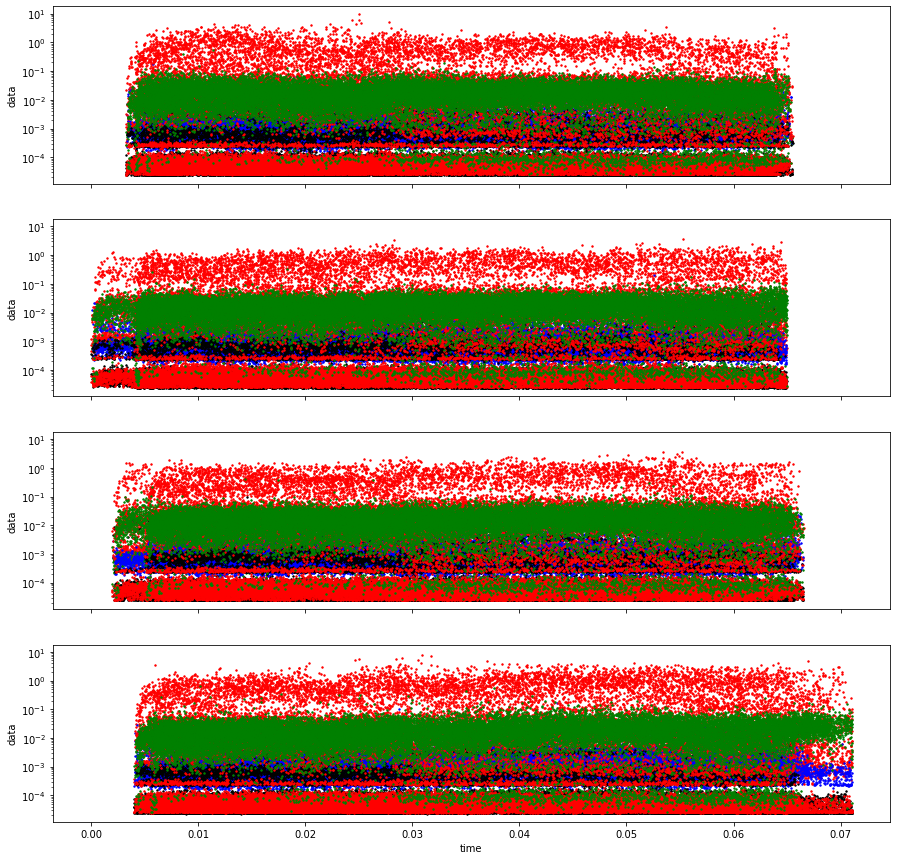

In [119]:
_, ax = plt.subplots(4, 1, figsize=(15, 15), sharey=True, sharex=True)
generic_df.loc[:, "time"] = normalize(generic_df.loc[:, "time"])


for i in range(4):
    generic_df[(generic_df.region == i) & (generic_df.type == 0)].sample(frac=1).sort_values("time").plot(x="time", y="data", logy=True, kind='scatter', s=2, ax=ax[i], color='r')
    generic_df[(generic_df.region == i) & (generic_df.type == 1)].sample(frac=1).sort_values("time").plot(x="time", y="data", logy=True, kind='scatter', s=2, ax=ax[i], color='g')
    generic_df[(generic_df.region == i) & (generic_df.type == 2)].sample(frac=1).sort_values("time").plot(x="time", y="data", logy=True, kind='scatter', s=2, ax=ax[i], color='b')
    generic_df[(generic_df.region == i) & (generic_df.type == 3)].sample(frac=1).sort_values("time").plot(x="time", y="data", logy=True, kind='scatter', s=2, ax=ax[i], color='k')
    generic_df[(generic_df.region == i) & (generic_df.type == 4)].sample(frac=1).sort_values("time").plot(x="time", y="data", logy=True, kind='scatter', s=2, ax=ax[i], color='r')
    generic_df[(generic_df.region == i) & (generic_df.type == 5)].sample(frac=1).sort_values("time").plot(x="time", y="data", logy=True, kind='scatter', s=2, ax=ax[i], color='g')
    # generic_df[(generic_df.region == i)].sample(frac=1).sort_values("from").plot(x="from", y="diff", logy=True, kind='scatter', s=2, ax=ax[i], color='g')  
    # generic_df[(generic_df.region == i)].sample(frac=1).sort_values("from").plot(x="from", y="diff", logy=True, kind='scatter', s=2, ax=ax[i], color='b')
    # generic_df[(generic_df.region == i)].sample(frac=1).sort_values("from").plot(x="from", y="diff", logy=True, kind='scatter', s=2, ax=ax[i], color='k')



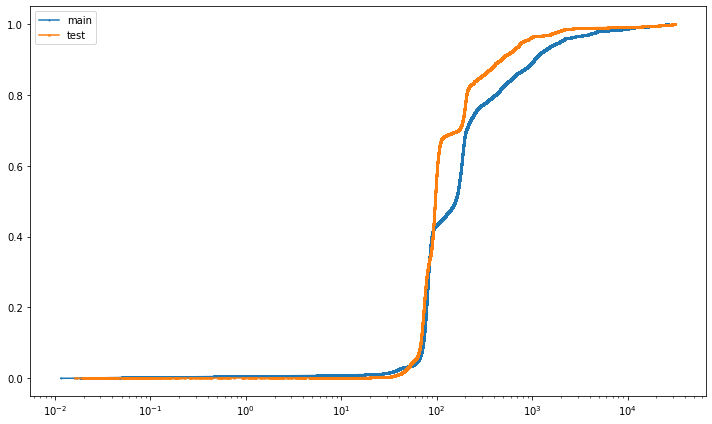

In [24]:
_, ax = plt.subplots(1, 1, figsize=(10, 6))
scale = "log"
plot_cdf(df1["diff"], ax=ax,  label="main", scale=scale, marker='.')
plot_cdf(df2["diff"], ax=ax, label="test", scale=scale, marker='x')
plt.legend()
plt.tight_layout()

<AxesSubplot:xlabel='time'>

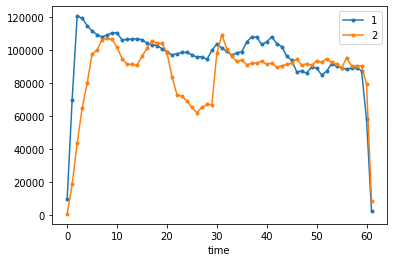

In [76]:
PREFIX1 = "file:/home/ctring/data/detock/test/ycsb/ddr_ts-hot10000mp0mh15"
PREFIX2 = "file:/home/ctring/data/detock/main/ycsb/ddr_ts-hot10000mp0mh15"

PREFIX1 = "file:/home/ctring/data/detock/main/ycsb/baseline-hot100mp0mh10"
PREFIX2 = "file:/home/ctring/data/detock/main/ycsb/baseline-hot100mp0mh15"

PREFIX1 = "file:/home/ctring/data/detock/test2/ycsb-4/ddr_ts-hot10000"
PREFIX2 = "file:/home/ctring/data/detock/test2/ycsb-4/ddr_ts-hot100"

def throughput_over_time(spark, prefix):
    return transactions_csv(spark, prefix, 0)\
        .withColumn("time", (col("sent_at") / 1000000000).cast(T.IntegerType()))\
        .groupBy("time")\
        .agg(
            (
                F.count("time") * (100/sample_rate(spark, prefix))
            ).alias("throughput")
        )\
        .orderBy("time")

throughput_over_time1_df = throughput_over_time(spark, PREFIX1).toPandas()
throughput_over_time1_df.loc[:, "time"] = normalize(throughput_over_time1_df["time"])

throughput_over_time2_df = throughput_over_time(spark, PREFIX2).toPandas()
throughput_over_time2_df.loc[:, "time"] = normalize(throughput_over_time2_df["time"])

_, ax = plt.subplots(1, 1)
throughput_over_time1_df.plot(ax=ax, x="time", y="throughput", label="1", marker='.')
throughput_over_time2_df.plot(ax=ax, x="time", y="throughput", label="2", marker='.')

In [163]:
def event_diff_server(spark, prefix, from_event, to_event, groupby_region=False, groupby_machine=True, **kwargs):
    groupby = ["txn_id"]
    if groupby_region:
        groupby.append("region")
    if groupby_machine:
        groupby.append("partition")
    events = events_csv(spark, prefix, True)\
        .where(col("event").isin([from_event, to_event]))\
        .groupBy(*groupby).pivot("event").max("time")\
        .select(
            *groupby,
            col(from_event).alias("from"),
            col(to_event).alias("to"),
            ((col(to_event) - col(from_event)) / 1000000).alias(f"diff")
        )\
        .dropna()
    return events

In [173]:
df_thrp = events_throughput(spark,f"file:/home/ctring/data/detock/test/ycsb/ddr_ts-hot10000mp0mh15", 100, True).toPandas()
df_thrp

,event,time,throughput
0,DISPATCHED_SLOW,1652886270,74.0
1,ENTER_SCHEDULER,1652886270,3968.0
2,EXIT_LOG_MANAGER,1652886270,4331.0
3,EXIT_WORKER,1652886270,3530.0
4,ENTER_SERVER,1652886270,898.0
...,...,...,...
730,EXIT_WORKER,1652886336,3877.0
731,ENTER_WORKER,1652886337,1546.0
732,DISPATCHED_SLOW,1652886337,1516.0
733,EXIT_WORKER,1652886337,1546.0


<AxesSubplot:xlabel='time'>

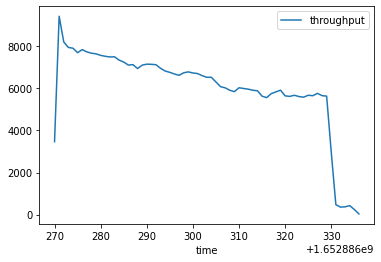

In [175]:
df_thrp[df_thrp.event == "ENTER_LOG_MANAGER_IN_BATCH"].plot(x="time", y="throughput")

NameError: name 'dfx' is not defined

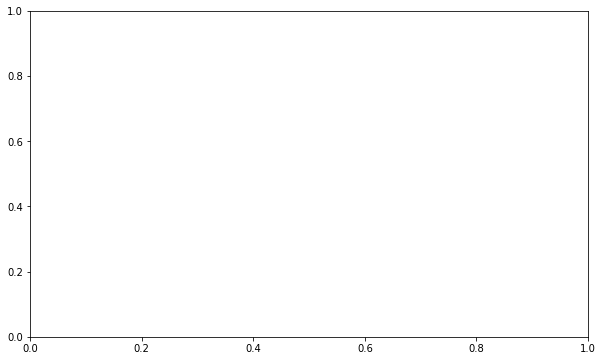

In [310]:
_, ax = plt.subplots(1, 1, figsize=(10, 6))
# plot_cdf(ax, df2["diff"], label="baseline", linewidth=0)
plot_cdf(ax, dfx.loc[dfx["coordinator_region"] == 0,"diff"], label="0", linewidth=0)
plot_cdf(ax, dfx.loc[dfx["coordinator_region"] == 1,"diff"], label="1", linewidth=0)
plot_cdf(ax, dfx.loc[dfx["coordinator_region"] == 2,"diff"], label="2", linewidth=0)
plot_cdf(ax, dfx.loc[dfx["coordinator_region"] == 3,"diff"], label="3", linewidth=0)
plot_cdf(ax, dfx.loc[dfx["coordinator_region"] == 4,"diff"], label="4", linewidth=0)
plot_cdf(ax, dfx.loc[dfx["coordinator_region"] == 5,"diff"], label="5", linewidth=0)
plot_cdf(ax, dfx.loc[dfx["coordinator_region"] == 6,"diff"], label="6", linewidth=0)
plot_cdf(ax, dfx.loc[dfx["coordinator_region"] == 7,"diff"], label="7", linewidth=0)
plt.legend()
plt.tight_layout()

In [4]:
PREFIX = "quick/latency"
SAMPLE = 1.0

from_event = "ENTER_LOCAL_BATCH"
to_event = "EXIT_SEQUENCER_IN_BATCH"

dfx = event_diff(spark, f"{PREFIX}/baseline", from_event, to_event, new_version=True)\
    .sample(fraction=SAMPLE)\
    .toPandas()

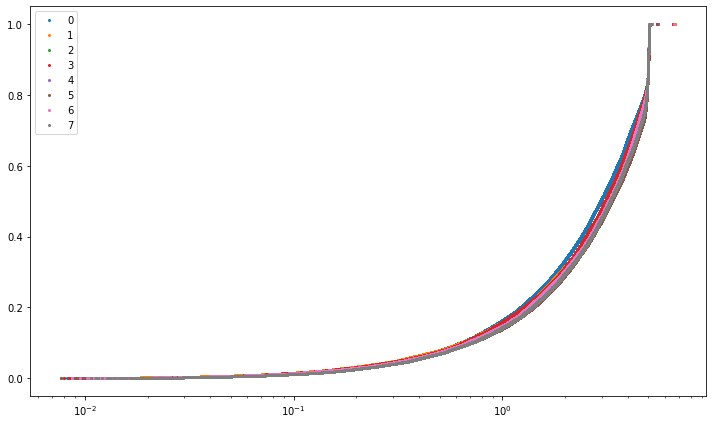

In [6]:
_, ax = plt.subplots(1, 1, figsize=(10, 6))
# plot_cdf(ax, df2["diff"], label="baseline", linewidth=0)
plot_cdf(ax, dfx.loc[dfx["coordinator_region"] == 0,"diff"], label="0", linewidth=0)
plot_cdf(ax, dfx.loc[dfx["coordinator_region"] == 1,"diff"], label="1", linewidth=0)
plot_cdf(ax, dfx.loc[dfx["coordinator_region"] == 2,"diff"], label="2", linewidth=0)
plot_cdf(ax, dfx.loc[dfx["coordinator_region"] == 3,"diff"], label="3", linewidth=0)
plot_cdf(ax, dfx.loc[dfx["coordinator_region"] == 4,"diff"], label="4", linewidth=0)
plot_cdf(ax, dfx.loc[dfx["coordinator_region"] == 5,"diff"], label="5", linewidth=0)
plot_cdf(ax, dfx.loc[dfx["coordinator_region"] == 6,"diff"], label="6", linewidth=0)
plot_cdf(ax, dfx.loc[dfx["coordinator_region"] == 7,"diff"], label="7", linewidth=0)
plt.legend()
plt.tight_layout()

In [426]:
prefix = "quick/ycsb/baseline"

schema = StructType([
    StructField("type", T.LongType(), False),
    StructField("time", T.LongType(), False),
    StructField("data", T.LongType(), False),
    StructField("partition", T.IntegerType(), False),
    StructField("replica", T.IntegerType(), False),
])

df = spark.read.csv(
        f"{prefix}/server/0-0/generic.csv",
        header=True,
        schema=schema
    ).toPandas()
# df["time"] = normalize(df["time"])
# df["time"] /= 1000000000
df["data"] /= 1000000

<AxesSubplot:xlabel='time'>

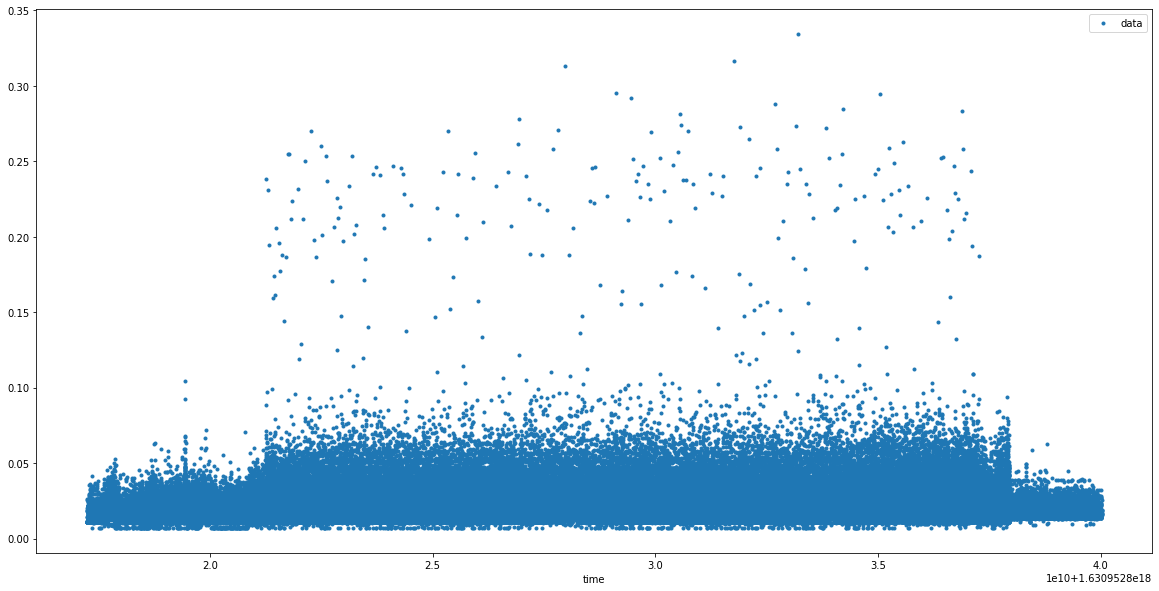

In [444]:
df[df.type == 2].plot(x="time", y="data", figsize=(20, 10), linewidth=0, marker='.')

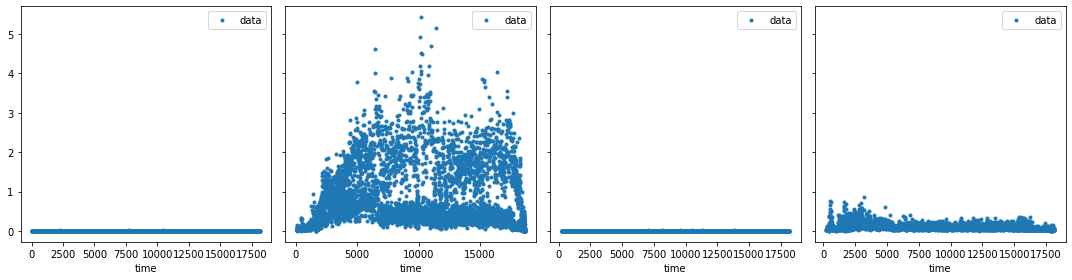

In [251]:
REPLICA = 0
PARTITION = 1
EVENT = 1
_, axes = plt.subplots(1, 4, figsize=(15, 4), sharey=True)
for i in range(4):
    d = df[(df.replica == REPLICA) & (df.partition == PARTITION) & (df.lm == i) & (df.event == EVENT)].sort_values("time")
    d.plot(ax=axes[i], x="time", y="data", linewidth=0, marker='.')

plt.tight_layout()

In [246]:
df[(df.replica == 0) & (df.partition == 1) & (df.lm == 1) & (df.event == 1)].sort_values("time")

,type,time,data,partition,replica,lm,event
49492,11,0.074432,0.087004,1,0,1,1
49494,11,0.074616,0.023151,1,0,1,1
49496,11,0.074799,0.033269,1,0,1,1
49498,11,0.074907,0.021888,1,0,1,1
49516,11,0.086154,0.060175,1,0,1,1
...,...,...,...,...,...,...,...
71542,11,18.630777,0.171769,1,0,1,1
71546,11,18.631161,0.024323,1,0,1,1
71550,11,18.631232,0.006578,1,0,1,1
71554,11,18.631264,0.008066,1,0,1,1


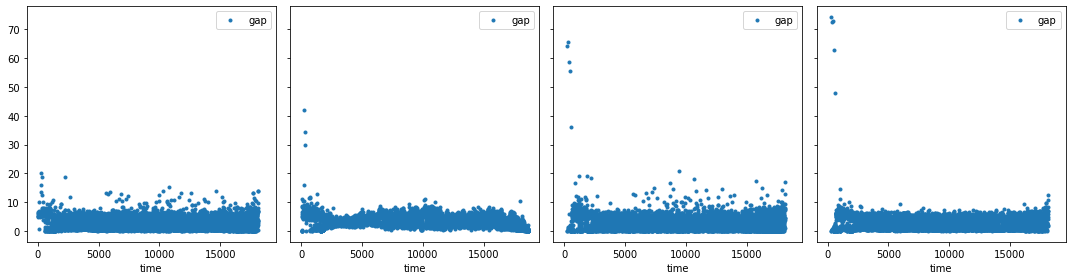

In [249]:
REPLICA = 0
PARTITION = 1
EVENT = 1
_, axes = plt.subplots(1, 4, figsize=(15, 4), sharey=True, sharex=True)
for i in range(4):
    d = df[(df.replica == REPLICA) & (df.partition == PARTITION) & (df.lm == i) & (df.event == EVENT)].sort_values("time").iloc[1:, :].reset_index()
    gap = d["time"].iloc[1:].reset_index(drop=True) - d["time"].iloc[:len(d)].reset_index(drop=True)
    gap = gap.reset_index(drop=True)
    d["gap"] = gap
    d.plot(ax=axes[i], x="time", y="gap", linewidth=0, marker='.')

plt.tight_layout()

In [445]:
PREFIX = "quick/ycsb"
SAMPLE = 1.0

from_event = "ENTER_SCHEDULER"
to_event = "ENTER_WORKER"

df1 = event_diff(spark, f"{PREFIX}/ddr_ts", from_event, to_event, groupby_home=True, groupby_machine=False)\
    .sample(fraction=SAMPLE)\
    .toPandas()
# df2 = event_diff(spark, f"{PREFIX}/baseline-hot10000mp100mh100", from_event, to_event, new_version=True)\
#     .sample(fraction=SAMPLE)\
#     .toPandas()


['txn_id', 'home']


In [ ]:
df1[df1["diff"] > 2000]

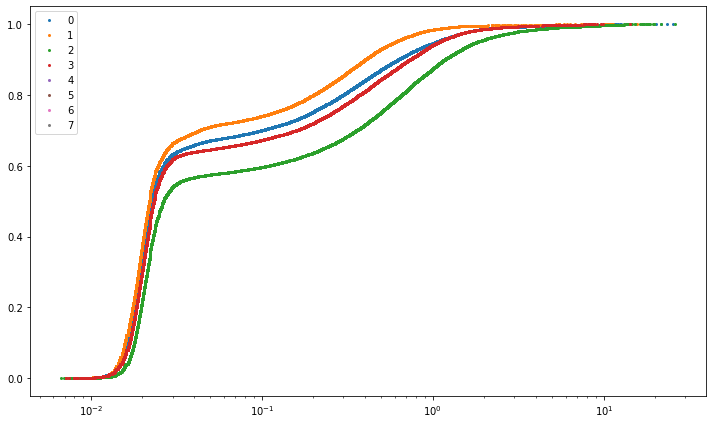

In [446]:
_, ax = plt.subplots(1, 1, figsize=(10, 6))
# plot_cdf(ax, df2["diff"], label="baseline", linewidth=0)
plot_cdf(ax, df1.loc[df1["coordinator_region"] == 0,"diff"], label="0", linewidth=0)
plot_cdf(ax, df1.loc[df1["coordinator_region"] == 1,"diff"], label="1", linewidth=0)
plot_cdf(ax, df1.loc[df1["coordinator_region"] == 2,"diff"], label="2", linewidth=0)
plot_cdf(ax, df1.loc[df1["coordinator_region"] == 3,"diff"], label="3", linewidth=0)
plot_cdf(ax, df1.loc[df1["coordinator_region"] == 4,"diff"], label="4", linewidth=0)
plot_cdf(ax, df1.loc[df1["coordinator_region"] == 5,"diff"], label="5", linewidth=0)
plot_cdf(ax, df1.loc[df1["coordinator_region"] == 6,"diff"], label="6", linewidth=0)
plot_cdf(ax, df1.loc[df1["coordinator_region"] == 7,"diff"], label="7", linewidth=0)
plt.legend()
plt.tight_layout()

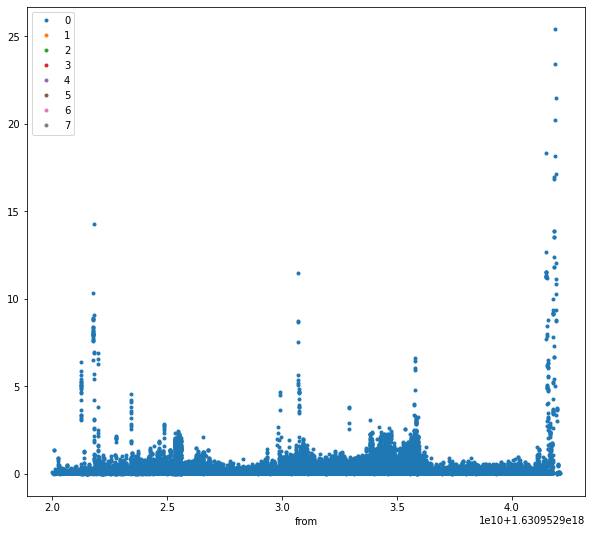

In [447]:
_, ax = plt.subplots(1, 1, figsize=(10, 9))

regions = range(8)
region = 0

from_df = df1.loc[df1["coordinator_region"] == region, :].sort_values("from")
for i in regions:
    from_df.loc[from_df["home"] == i, :].plot(ax=ax, label=f"{i}", x="from", y="diff", linewidth=0, marker='.')

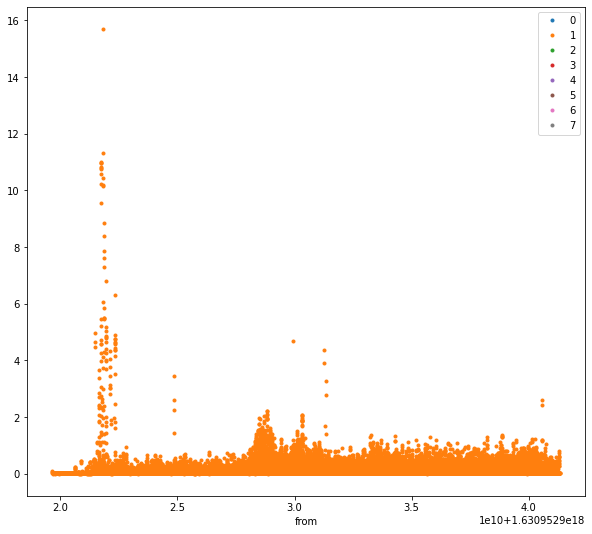

In [448]:
_, ax = plt.subplots(1, 1, figsize=(10, 9))

region = 1

from_df = df1.loc[df1["coordinator_region"] == region, :].sort_values("from")
for i in regions:
    from_df.loc[from_df["home"] == i, :].plot(ax=ax, label=f"{i}", x="from", y="diff", linewidth=0, marker='.')

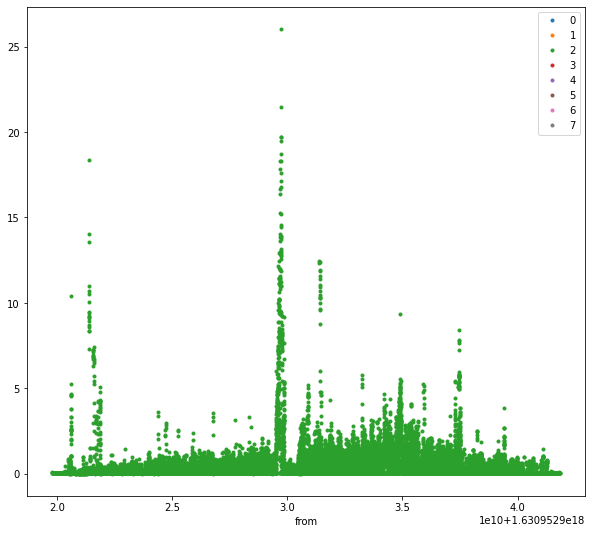

In [449]:
_, ax = plt.subplots(1, 1, figsize=(10, 9))

region = 2

from_df = df1.loc[df1["coordinator_region"] == region, :].sort_values("from")
for i in regions:
    from_df.loc[from_df["home"] == i, :].plot(ax=ax, label=f"{i}", x="from", y="diff", linewidth=0, marker='.')


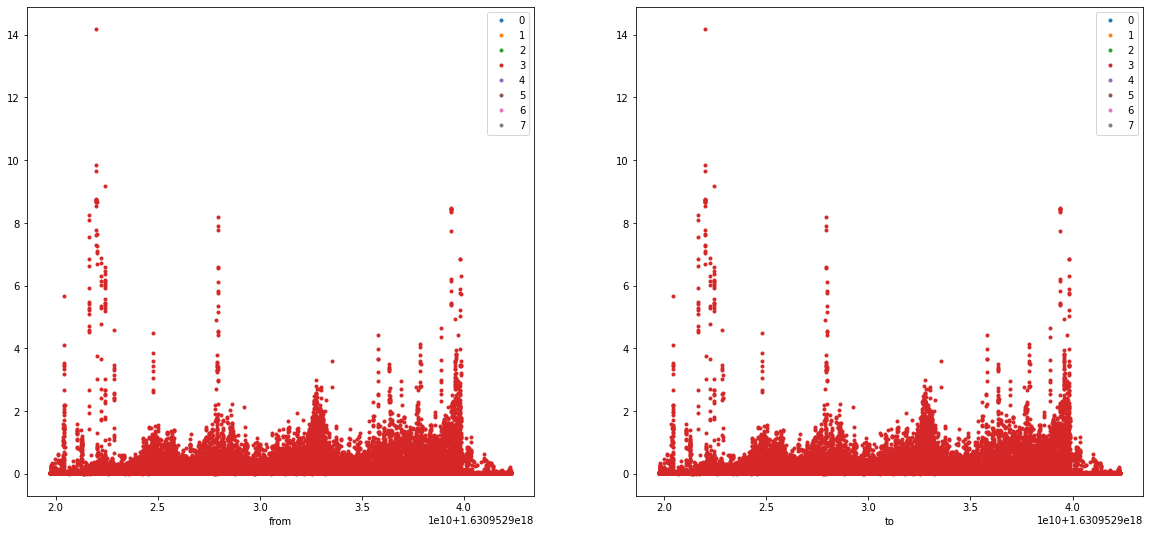

In [450]:
_, axes = plt.subplots(1, 2, figsize=(20, 9))

region = 3

from_df = df1.loc[df1["coordinator_region"] == region, :].sort_values("from")
for i in regions:
    from_df.loc[from_df["home"] == i, :].plot(ax=axes[0], label=f"{i}", x="from", y="diff", linewidth=0, marker='.')
    
to_df = df1.loc[df1["coordinator_region"] == region, :].sort_values("to")
for i in regions:
    to_df.loc[to_df["home"] == i, :].plot(ax=axes[1], label=f"{i}", x="to", y="diff", linewidth=0, marker='.')

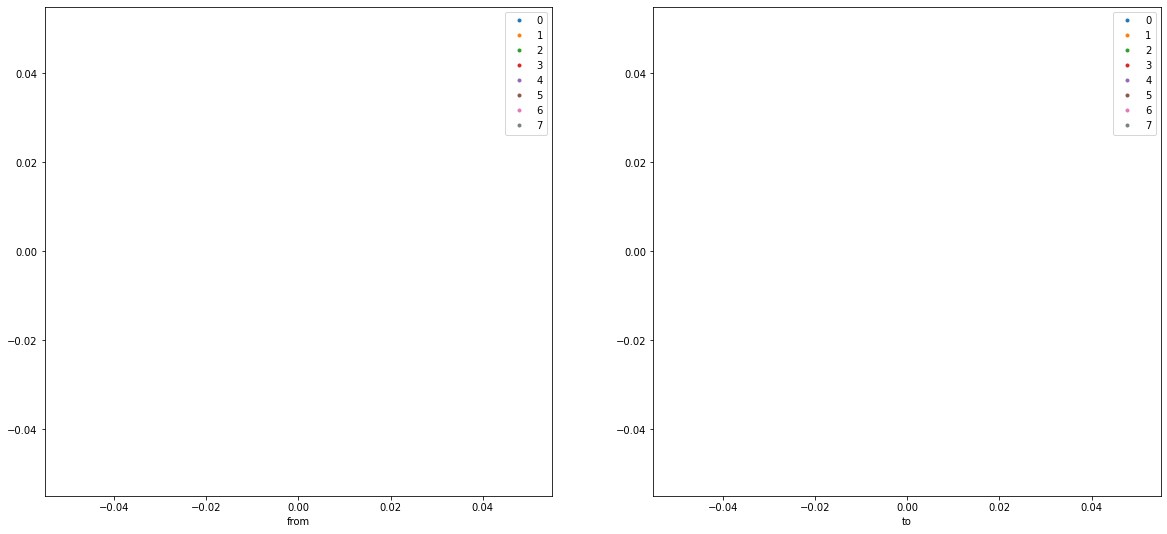

In [451]:
_, axes = plt.subplots(1, 2, figsize=(20, 9))

region = 4

from_df = df1.loc[df1["coordinator_region"] == region, :].sort_values("from")
for i in regions:
    from_df.loc[from_df["home"] == i, :].plot(ax=axes[0], label=f"{i}", x="from", y="diff", linewidth=0, marker='.')
    
to_df = df1.loc[df1["coordinator_region"] == region, :].sort_values("to")
for i in regions:
    to_df.loc[to_df["home"] == i, :].plot(ax=axes[1], label=f"{i}", x="to", y="diff", linewidth=0, marker='.')

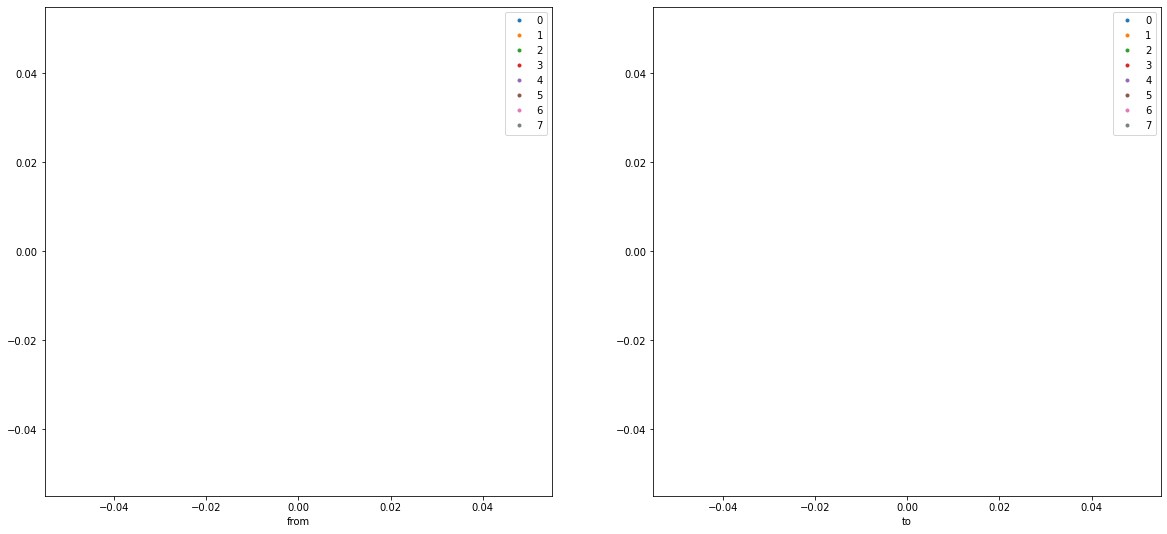

In [452]:
_, axes = plt.subplots(1, 2, figsize=(20, 9))

region = 5

from_df = df1.loc[df1["coordinator_region"] == region, :].sort_values("from")
for i in regions:
    from_df.loc[from_df["home"] == i, :].plot(ax=axes[0], label=f"{i}", x="from", y="diff", linewidth=0, marker='.')
    
to_df = df1.loc[df1["coordinator_region"] == region, :].sort_values("to")
for i in regions:
    to_df.loc[to_df["home"] == i, :].plot(ax=axes[1], label=f"{i}", x="to", y="diff", linewidth=0, marker='.')

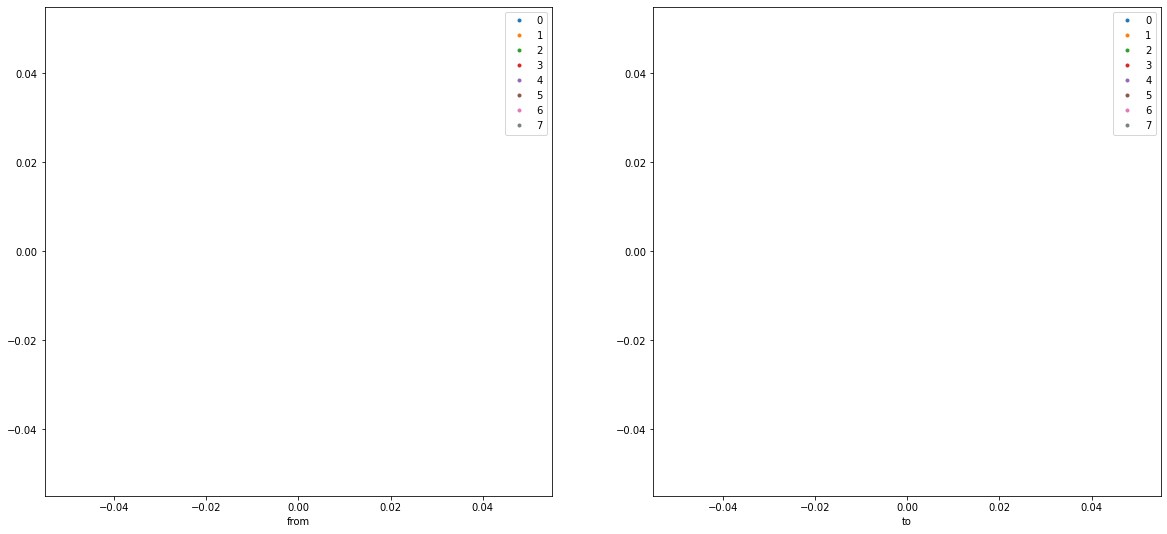

In [436]:
_, axes = plt.subplots(1, 2, figsize=(20, 9))

region = 6

from_df = df1.loc[df1["coordinator_region"] == region, :].sort_values("from")
for i in regions:
    from_df.loc[from_df["home"] == i, :].plot(ax=axes[0], label=f"{i}", x="from", y="diff", linewidth=0, marker='.')
    
to_df = df1.loc[df1["coordinator_region"] == region, :].sort_values("to")
for i in regions:
    to_df.loc[to_df["home"] == i, :].plot(ax=axes[1], label=f"{i}", x="to", y="diff", linewidth=0, marker='.')

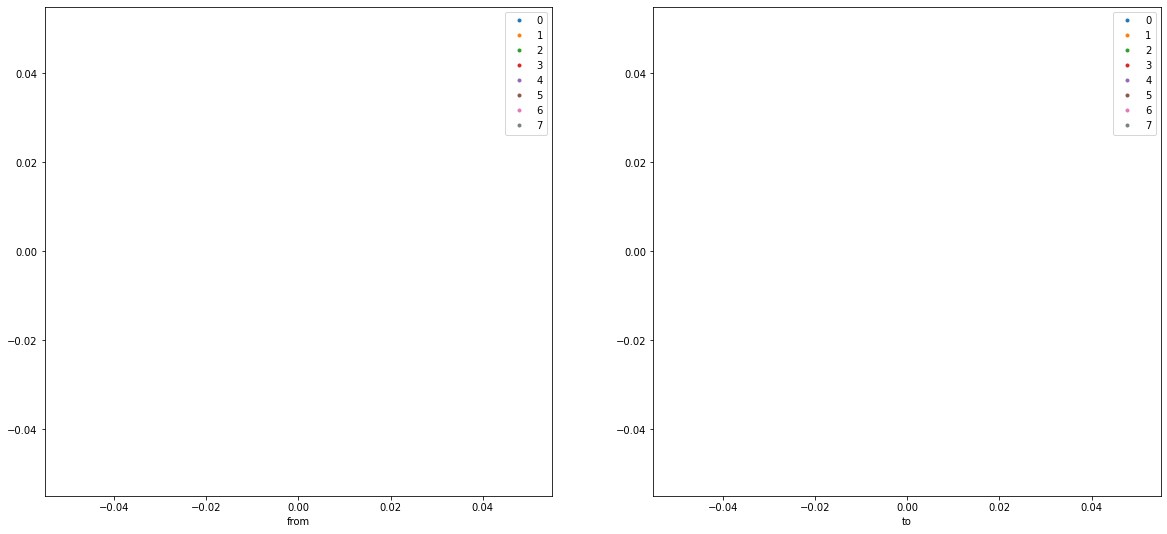

In [437]:
_, axes = plt.subplots(1, 2, figsize=(20, 9))

region = 7

from_df = df1.loc[df1["coordinator_region"] == region, :].sort_values("from")
for i in regions:
    from_df.loc[from_df["home"] == i, :].plot(ax=axes[0], label=f"{i}", x="from", y="diff", linewidth=0, marker='.')
    
to_df = df1.loc[df1["coordinator_region"] == region, :].sort_values("to")
for i in regions:
    to_df.loc[to_df["home"] == i, :].plot(ax=axes[1], label=f"{i}", x="to", y="diff", linewidth=0, marker='.')

In [350]:
def get_txn_events_alls(region):
    PREFIX = "main/ycsb-scuffed2/baseline-hot10000mp0mh0"
    SAMPLE = 1.0

    from_event = "EXIT_LOG_MANAGER"
    to_event = "ENTER_SCHEDULER"

    txn_info = transactions_csv(spark, PREFIX)\
        .withColumn("num_replicas", F.size(col("replicas")))\
        .withColumn("num_partitions", F.size(col("partitions")))\
        .withColumn("coordinator_region", col("machine").cast(T.IntegerType()))\
        .drop("min_received_at", "max_received_at", "sent_at", "received_at", "machine")\
        .where(col("coordinator_region") == region)

    txn_events = txn_events_csv(spark, PREFIX)\
        .where(col("event").isin([from_event, to_event]))\
        .cache()

    txn_events_time = txn_events\
        .groupBy("txn_id", "home").pivot("event").min("time")\
        .select(
            "txn_id",
            "home",
            col(from_event).alias("from_time"),
            col(to_event).alias("to_time"),
            ((col(to_event) - col(from_event)) / 1000000).alias(f"diff")
        )\
        .dropna()
    
    txn_events_machine = txn_events\
        .groupBy("txn_id", "home").pivot("event").min("machine")\
        .select(
            "txn_id",
            "home",
            col(from_event).alias("from_machine"),
            col(to_event).alias("to_machine"),
        )\
        .dropna()

    txn_events_all = txn_events_time.join(txn_events_machine, on=["txn_id", "home"])
    return txn_events_all.join(txn_info, on="txn_id").toPandas()


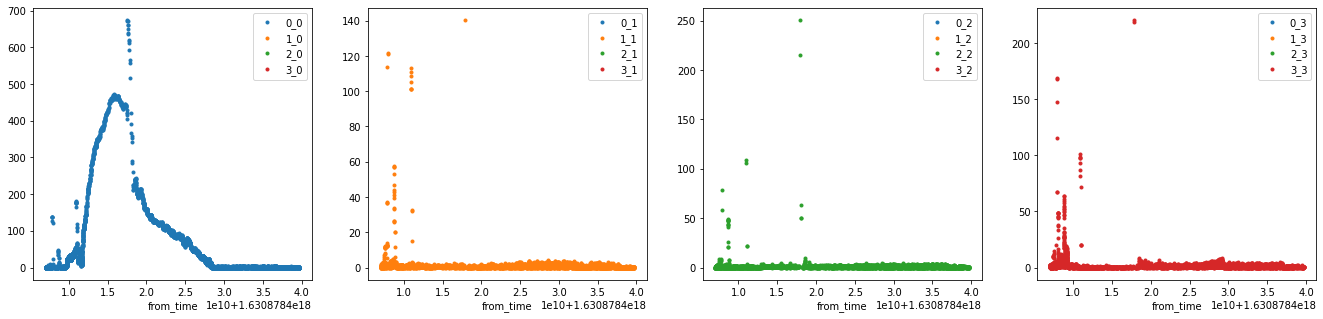

In [351]:
_, ax = plt.subplots(1, 4, figsize=(23, 5))

df = get_txn_events_alls(0)
from_machines = sorted(df["from_machine"].unique())
to_machines = sorted(df["to_machine"].unique())
from_df = df.sort_values("from_time")
for i, to in enumerate(to_machines):
    for fr in from_machines:
        from_df[(from_df["from_machine"] == fr) & (from_df["to_machine"] == to)].plot(ax=ax[i], label=f'{fr}_{to}', x="from_time", y="diff", linewidth=0, marker='.')

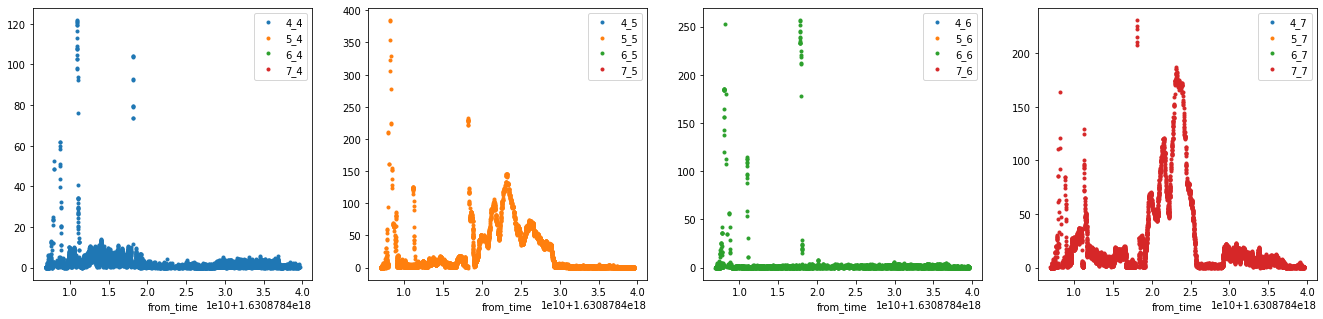

In [352]:
_, ax = plt.subplots(1, 4, figsize=(23, 5))

df = get_txn_events_alls(1)
from_machines = sorted(df["from_machine"].unique())
to_machines = sorted(df["to_machine"].unique())
from_df = df.sort_values("from_time")
for i, to in enumerate(to_machines):
    for fr in from_machines:
        from_df[(from_df["from_machine"] == fr) & (from_df["to_machine"] == to)].plot(ax=ax[i], label=f'{fr}_{to}', x="from_time", y="diff", linewidth=0, marker='.')

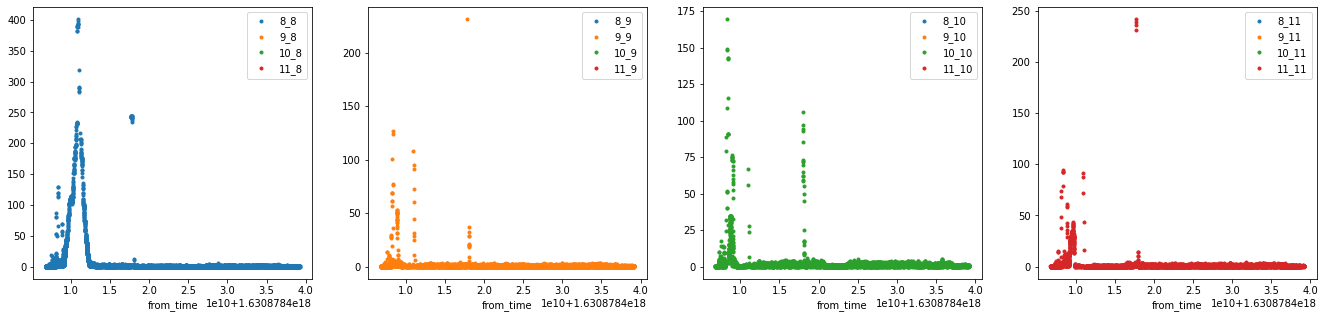

In [353]:
_, ax = plt.subplots(1, 4, figsize=(23, 5))

df = get_txn_events_alls(2)
from_machines = sorted(df["from_machine"].unique())
to_machines = sorted(df["to_machine"].unique())
from_df = df.sort_values("from_time")
for i, to in enumerate(to_machines):
    for fr in from_machines:
        from_df[(from_df["from_machine"] == fr) & (from_df["to_machine"] == to)].plot(ax=ax[i], label=f'{fr}_{to}', x="from_time", y="diff", linewidth=0, marker='.')

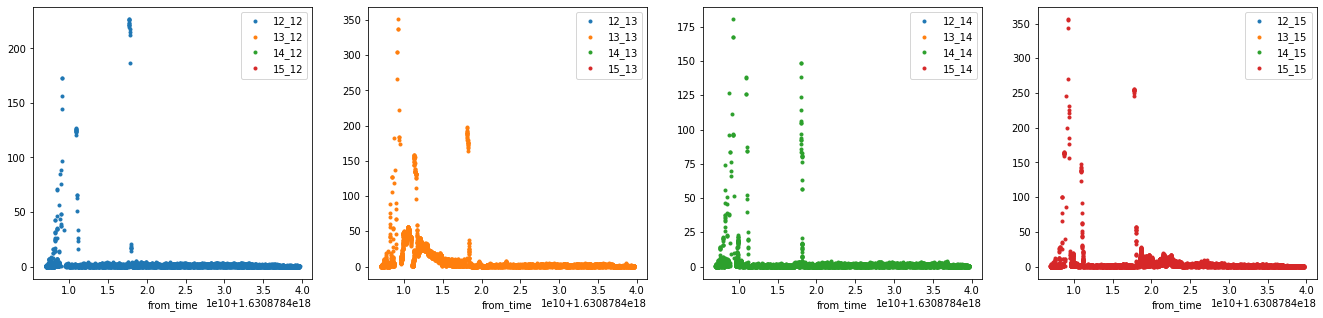

In [354]:
_, ax = plt.subplots(1, 4, figsize=(23, 5))

df = get_txn_events_alls(3)
from_machines = sorted(df["from_machine"].unique())
to_machines = sorted(df["to_machine"].unique())
from_df = df.sort_values("from_time")
for i, to in enumerate(to_machines):
    for fr in from_machines:
        from_df[(from_df["from_machine"] == fr) & (from_df["to_machine"] == to)].plot(ax=ax[i], label=f'{fr}_{to}', x="from_time", y="diff", linewidth=0, marker='.')

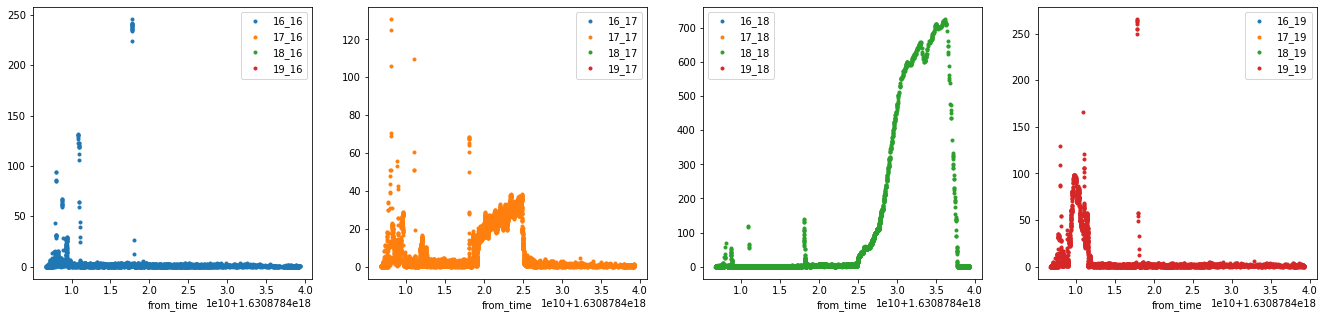

In [355]:
_, ax = plt.subplots(1, 4, figsize=(23, 5))

df = get_txn_events_alls(4)
from_machines = sorted(df["from_machine"].unique())
to_machines = sorted(df["to_machine"].unique())
from_df = df.sort_values("from_time")
for i, to in enumerate(to_machines):
    for fr in from_machines:
        from_df[(from_df["from_machine"] == fr) & (from_df["to_machine"] == to)].plot(ax=ax[i], label=f'{fr}_{to}', x="from_time", y="diff", linewidth=0, marker='.')

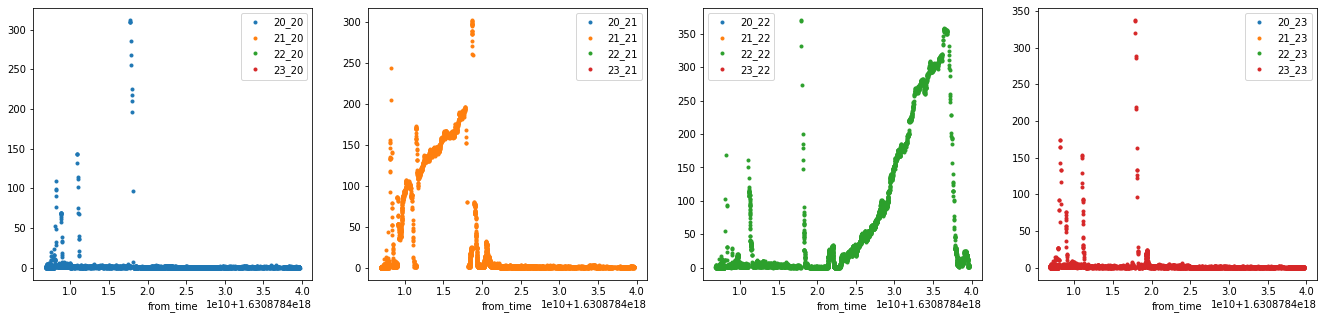

In [359]:
_, ax = plt.subplots(1, 4, figsize=(23, 5))

df = get_txn_events_alls(5)
from_machines = sorted(df["from_machine"].unique())
to_machines = sorted(df["to_machine"].unique())
from_df = df.sort_values("from_time")
for i, to in enumerate(to_machines):
    for fr in from_machines:
        from_df[(from_df["from_machine"] == fr) & (from_df["to_machine"] == to)].plot(ax=ax[i], label=f'{fr}_{to}', x="from_time", y="diff", linewidth=0, marker='.')

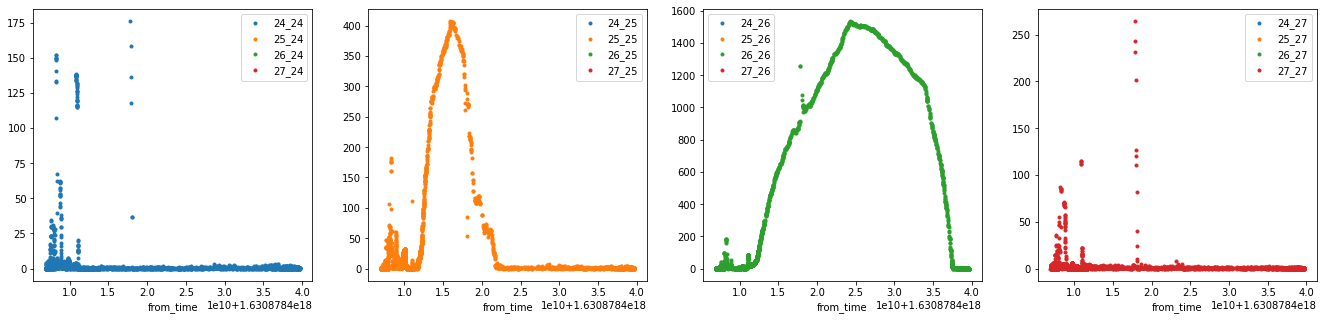

In [357]:
_, ax = plt.subplots(1, 4, figsize=(23, 5))

df = get_txn_events_alls(6)
from_machines = sorted(df["from_machine"].unique())
to_machines = sorted(df["to_machine"].unique())
from_df = df.sort_values("from_time")
for i, to in enumerate(to_machines):
    for fr in from_machines:
        from_df[(from_df["from_machine"] == fr) & (from_df["to_machine"] == to)].plot(ax=ax[i], label=f'{fr}_{to}', x="from_time", y="diff", linewidth=0, marker='.')

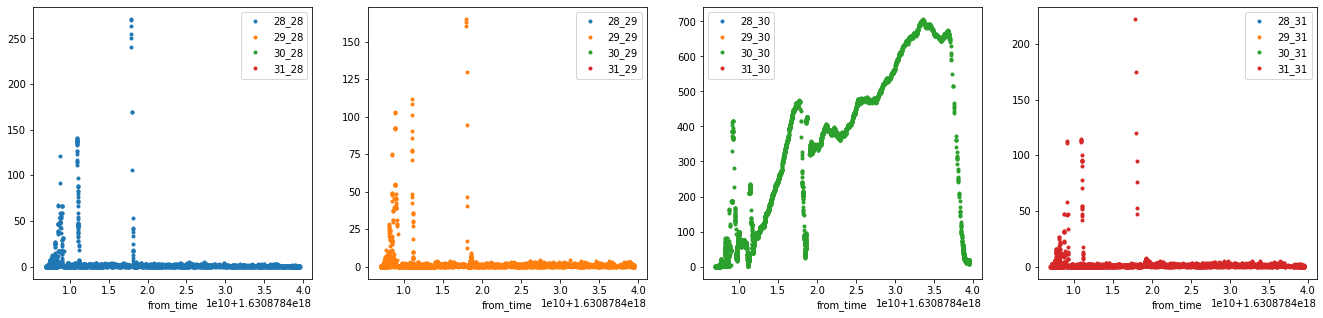

In [358]:
_, ax = plt.subplots(1, 4, figsize=(23, 5))

df = get_txn_events_alls(7)
from_machines = sorted(df["from_machine"].unique())
to_machines = sorted(df["to_machine"].unique())
from_df = df.sort_values("from_time")
for i, to in enumerate(to_machines):
    for fr in from_machines:
        from_df[(from_df["from_machine"] == fr) & (from_df["to_machine"] == to)].plot(ax=ax[i], label=f'{fr}_{to}', x="from_time", y="diff", linewidth=0, marker='.')

## Overall

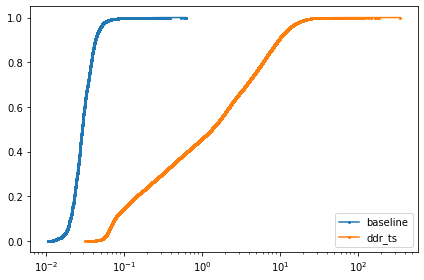

In [20]:
_, ax = plt.subplots(1, 1)
plot_cdf(ax, baseline_df["diff"], label="baseline")
plot_cdf(ax, ddr_ts_df["diff"], label="ddr_ts")
plt.legend()
plt.tight_layout()

# By type

### single-home

In [ ]:
_, ax = plt.subplots(1, 1)
plot_cdf(ax, baseline_df.loc[baseline_df["num_replicas"] == 1, "diff"], label="baseline")
plot_cdf(ax, ddr_ts_df.loc[ddr_ts_df["num_replicas"] == 1, "diff"], label="ddr_ts")
plt.legend()
plt.tight_layout()

### multi-home

In [ ]:
_, ax = plt.subplots(1, 1)
plot_cdf(ax, baseline_df.loc[baseline_df["num_replicas"] > 1, "diff"], label="baseline")
plot_cdf(ax, ddr_ts_df.loc[ddr_ts_df["num_replicas"] > 1, "diff"], label="ddr_ts")
plt.legend()
plt.tight_layout()

## By region

### single-home

In [ ]:
rows = 2
cols = 4
_, ax = plt.subplots(rows, cols, figsize=(15, 7))

plot_cdf_per_region(ax, baseline_df[baseline_df["num_replicas"] == 1], "diff", label="baseline")
plot_cdf_per_region(ax, ddr_ts_df[ddr_ts_df["num_replicas"] == 1], "diff", label="ddr_ts")
plt.legend()
plt.tight_layout()

### multi-home

In [ ]:
rows = 2
cols = 4
_, ax = plt.subplots(rows, cols, figsize=(15, 7))

plot_cdf_per_region(ax, baseline_df[baseline_df["num_replicas"] > 1], "diff", label="baseline")
plot_cdf_per_region(ax, ddr_ts_df[ddr_ts_df["num_replicas"] > 1], "diff", label="ddr_ts")
plt.legend()
plt.tight_layout()

# Sequencer

In [ ]:
PREFIX = "main/ycsb"
SAMPLE = 1.0
seq_baseline_df = event_diff(spark, f"{PREFIX}/baseline-hot100000mp100mh0", "ENTER_SCHEDULER", "ENTER_WORKER", new_version=True)\
    .sample(fraction=SAMPLE)\
    .toPandas()
# seq_ddr_ts_df = event_diff(spark, f"{PREFIX}/ddr_ts-clients50", "ENTER_SEQUENCER", "ENTER_LOCAL_BATCH", new_version=True)\
#     .sample(fraction=SAMPLE)\
#     .toPandas()

## Overall

In [ ]:
_, ax = plt.subplots(1, 1)
plot_cdf(ax, seq_baseline_df["diff"], label="baseline")
# plot_cdf(ax, seq_ddr_ts_df["diff"], label="ddr_ts")
plt.legend()
plt.tight_layout()

## By type

### single-home

In [ ]:
_, ax = plt.subplots(1, 1)
plot_cdf(ax, seq_baseline_df.loc[seq_baseline_df["num_replicas"] == 1, "diff"], label="baseline")
plot_cdf(ax, seq_ddr_ts_df.loc[seq_ddr_ts_df["num_replicas"] == 1, "diff"], label="ddr_ts")
plt.legend()
plt.tight_layout()

### multi-home

In [ ]:
_, ax = plt.subplots(1, 1)
plot_cdf(ax, seq_baseline_df.loc[seq_baseline_df["num_replicas"] > 1, "diff"], label="baseline")
plot_cdf(ax, seq_ddr_ts_df.loc[seq_ddr_ts_df["num_replicas"] > 1, "diff"], label="ddr_ts")
plt.legend()
plt.tight_layout()

## By region

### single-home

In [ ]:
rows = 2
cols = 4
_, ax = plt.subplots(rows, cols, figsize=(15, 7))

plot_cdf_per_region(ax, seq_baseline_df[seq_baseline_df["num_replicas"] == 1], "diff", label="baseline")
plot_cdf_per_region(ax, seq_ddr_ts_df[seq_ddr_ts_df["num_replicas"] == 1], "diff", label="ddr_ts")
plt.legend()
plt.tight_layout()

### multi-home

In [ ]:
rows = 2
cols = 4
_, ax = plt.subplots(rows, cols, figsize=(15, 7))

plot_cdf_per_region(ax, seq_baseline_df[seq_baseline_df["num_replicas"] > 1], "diff", label="baseline")
plot_cdf_per_region(ax, seq_ddr_ts_df[seq_ddr_ts_df["num_replicas"] > 1], "diff", label="ddr_ts")
plt.legend()
plt.tight_layout()

# Scratch space

In [14]:
PREFIX = "quick/ycsb-no-remove-redirection/"
SAMPLE = 1.0
# baseline_df = event_diff(spark, f"{PREFIX}/baseline-hot100000mp0mh0", "ENTER_WORKER", "EXIT_WORKER", new_version=True)\
#     .sample(fraction=SAMPLE)\
#     .toPandas()
# ddr_ts_df = event_diff(spark, f"{PREFIX}/ddr_ts-hot100mp100mh0", "ENTER_WORKER", "EXIT_WORKER", new_version=True)\
#     .sample(fraction=SAMPLE)\
#     .toPandas()

from_event = "ENTER_WORKER"
to_event = "EXIT_WORKER"

df1 = event_diff(spark, f"{PREFIX}/baseline", from_event, to_event, new_version=True)\
    .sample(fraction=SAMPLE)\
    .toPandas()
df2 = event_diff(spark, f"{PREFIX}/baseline_test", from_event, to_event, new_version=True)\
    .sample(fraction=SAMPLE)\
    .toPandas()

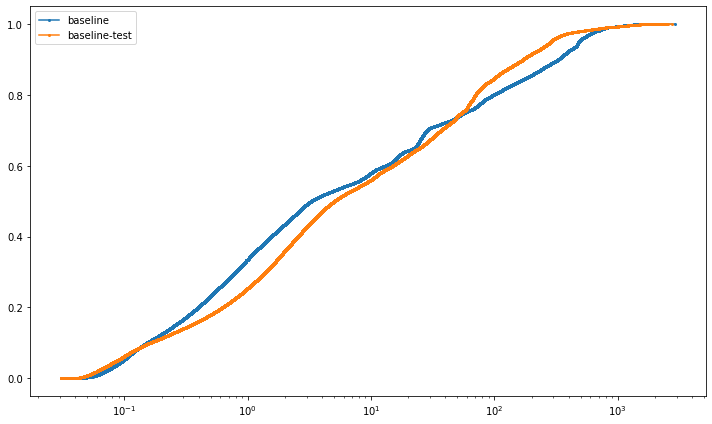

In [15]:
_, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_cdf(ax, df1["diff"], label="baseline")
plot_cdf(ax, df2["diff"], label="baseline-test")
plt.legend()
plt.tight_layout()

In [16]:
PREFIX = "quick/ycsb-no-remove-redirection/"
SAMPLE = 1.0
# baseline_df = event_diff(spark, f"{PREFIX}/baseline-hot100000mp0mh0", "ENTER_WORKER", "EXIT_WORKER", new_version=True)\
#     .sample(fraction=SAMPLE)\
#     .toPandas()
# ddr_ts_df = event_diff(spark, f"{PREFIX}/ddr_ts-hot100mp100mh0", "ENTER_WORKER", "EXIT_WORKER", new_version=True)\
#     .sample(fraction=SAMPLE)\
#     .toPandas()

from_event = "ENTER_SCHEDULER"
to_event = "ENTER_WORKER"

df1 = event_diff(spark, f"{PREFIX}/baseline", from_event, to_event, new_version=True)\
    .sample(fraction=SAMPLE)\
    .toPandas()
df2 = event_diff(spark, f"{PREFIX}/baseline_test", from_event, to_event, new_version=True)\
    .sample(fraction=SAMPLE)\
    .toPandas()

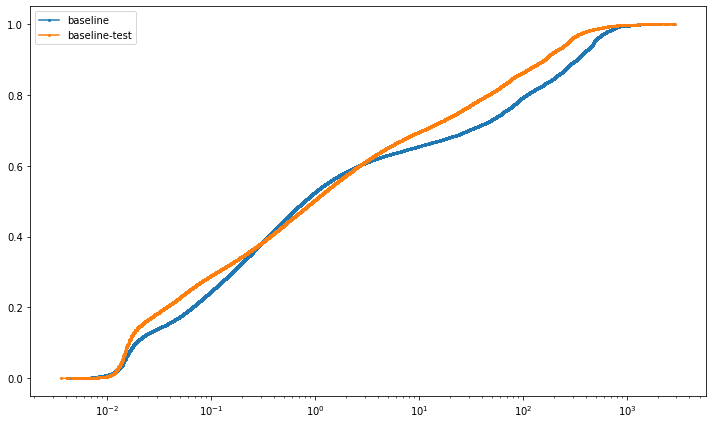

In [17]:
_, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_cdf(ax, df1["diff"], label="baseline")
plot_cdf(ax, df2["diff"], label="baseline-test")
plt.legend()
plt.tight_layout()